# Sentiment analysis of IMDB reviews

https://www.kaggle.com/c/word2vec-nlp-tutorial/data

The dataset contains 25000 IMDB movie reviews. The sentiment of reviews is binary, meaning the IMDB rating < 5 results in a sentiment score of 0, and rating >=7 have a sentiment score of 1. No individual movie has more than 30 reviews. 

In [2]:
import pandas as pd
import numpy as np
data = pd.read_csv('../data/reviews/labeledTrainData.tsv', sep='\t')
data.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [3]:
data['sentiment'].value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['review'], data['sentiment'], 
                                                    test_size=0.2, random_state=42, stratify=data['sentiment'])

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
vectorizer = HashingVectorizer(stop_words='english', n_features = 5000)
X_train_bag = vectorizer.fit_transform(X_train)
X_train_bag.shape

(20000, 5000)

In [7]:
X_test_bag = vectorizer.transform(X_test)

In [8]:
clf = LogisticRegression()
clf.fit(X_train_bag, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [9]:
from sklearn.metrics import classification_report
print classification_report(clf.predict(X_test_bag), y_test)

             precision    recall  f1-score   support

          0       0.83      0.86      0.84      2420
          1       0.86      0.83      0.85      2580

avg / total       0.85      0.85      0.85      5000



Результат логита вполне себе - значит, 5000 фичей в принципе достаточно, так и оставим.

In [10]:
import sys
sys.path.append('..')
import warnings
warnings.simplefilter('ignore')
from experiment import Experiment
from xgboost_experiment import XGBExperiment
from lightgbm_experiment import LGBExperiment
from catboost_experiment import CABExperiment

In [11]:
X_train, y_train, X_test, y_test, cat_cols = X_train_bag.toarray(), np.array(y_train), X_test_bag.toarray(), np.array(y_test), []

In [12]:
from sklearn.metrics import precision_recall_fscore_support

def run_default(Experiment, title, n_estimators):
    experiment = Experiment(learning_task,
                            n_estimators=n_estimators)
    cv_pairs, (dtrain, dtest), X_test_preprocessed = experiment.split_and_preprocess(X_train.copy(), y_train, 
                                                                X_test.copy(), y_test, 
                                                                cat_cols, n_splits=5)
 
    default_cv_result = experiment.run_cv(cv_pairs)
    experiment.print_result(default_cv_result, 'Default {} result on cv'.format(title))

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')

    default_test_losses = []
    fscores = {0: [], 1: [], 'average': []}
    durations = []
    
    for seed in range(5):
        
        test_result = experiment.run_test(dtrain, dtest, X_test_preprocessed, params=default_cv_result['params'],
                                          n_estimators=default_cv_result['best_n_estimators'], seed=seed)
        default_test_losses.append(test_result['loss'])
        preds, duration = test_result['preds'], test_result['eval_time']
        labels = np.array([1 if p > 0.5 else 0 for p in preds])
        metrics = precision_recall_fscore_support(y_test, labels)
        for cl in xrange(2):
            fscores[cl].append(metrics[2][cl])
        fscores['average'].append(precision_recall_fscore_support(y_test, labels,  average='weighted')[2])
        durations.append(duration)
        
        if seed == 4:
            print '\n', classification_report(y_test, labels)
        
        print 'For seed=%d Test\'s %s : %.5f' % (seed, experiment.metric, default_test_losses[-1])
    print '\nTest\'s %s mean: %.5f, Test\'s %s std: %.5f' % (experiment.metric, np.mean(default_test_losses),
                                                             experiment.metric, np.std(default_test_losses))
    print '\nMean f-score for class 0: {:.5f}\nMean f-score for class 1: {:.5f}'.format(np.mean(fscores[0]), np.mean(fscores[1]))
    print '\nMean average f-score: {:.5f}'.format(np.mean(fscores['average']))
                                                                            
    print '\n\nDurations:\n{}'.format(durations)
    print 'Average runtime: {:.3f} sec'.format(np.mean(durations))
    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')
    
    return ([np.mean(default_test_losses)] + [np.mean(fscores[cl]) for cl in fscores.keys()] + \
            [np.mean(durations), default_cv_result['best_n_estimators']])

In [13]:
learning_task = 'classification'

## XGBoost

In [13]:
%%time
xgb_default_test_result = run_default(XGBExperiment, "XGBoost", n_estimators=100)

Default XGBoost result on cv:

logloss = 0.3785286
best_n_estimators = 100
params = {'colsample_bytree': 1.0, 'silent': 1, 'eval_metric': 'logloss', 'colsample_bylevel': 1.0, 'min_child_weight': 1, 'subsample': 1.0, 'eta': 0.3, 'objective': 'binary:logistic', 'alpha': 0, 'seed': 0, 'max_depth': 6, 'gamma': 0, 'lambda': 1}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

For seed=0 Test's logloss : 0.37462
For seed=1 Test's logloss : 0.37462
For seed=2 Test's logloss : 0.37462
For seed=3 Test's logloss : 0.37462

             precision    recall  f1-score   support

          0       0.85      0.81      0.83      2500
          1       0.82      0.86      0.84      2500

avg / total       0.84      0.83      0.83      5000

For seed=4 Test's logloss : 0.37462

Test's logloss mean: 0.37462, Test's logloss std: 0.00000

Mean f-score for class 0: 0.83035
Mean f-score for class 1: 0.83940

Mean average f-score: 0.83488


Durations:
[62.696017026901245, 62.341416120529175, 64.249496936

## LightGBM

In [15]:
%%time
lgb_default_test_result = run_default(LGBExperiment, "LightGBM", n_estimators=100)

Default LightGBM result on cv:

logloss = 0.356826009628
best_n_estimators = 100
params = {'num_leaves': 127, 'verbose': -1, 'bagging_seed': 3, 'learning_rate': 0.1, 'data_random_seed': 1, 'min_data_in_leaf': 100, 'bagging_fraction': 1.0, 'metric': 'binary_logloss', 'feature_fraction_seed': 2, 'lambda_l1': 0, 'bagging_freq': 1, 'lambda_l2': 0, 'max_bin': 255, 'objective': 'binary', 'drop_seed': 4, 'min_sum_hessian_in_leaf': 10, 'feature_fraction': 1.0}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

For seed=0 Test's logloss : 0.34905
For seed=1 Test's logloss : 0.34905
For seed=2 Test's logloss : 0.34905
For seed=3 Test's logloss : 0.34905

             precision    recall  f1-score   support

          0       0.85      0.84      0.84      2500
          1       0.84      0.85      0.85      2500

avg / total       0.85      0.85      0.85      5000

For seed=4 Test's logloss : 0.34905

Test's logloss mean: 0.34905, Test's logloss std: 0.00000

Mean f-score for class 0: 0.8443

## CatBoost

In [16]:
%%time
cab_default_test_result = run_default(CABExperiment, "CatBoost", n_estimators=100)

Default CatBoost result on cv:

logloss = 0.51244261408
best_n_estimators = 100
params = {'rsm': 1.0, 'random_seed': 0, 'verbose': False, 'learning_rate': 0.03, 'ctr_border_count': 16, 'ctr_description': ['Borders', 'Counter'], 'depth': 6, 'fold_len_multiplier': 2, 'loss_function': 'Logloss', 'iterations': 100, 'l2_leaf_reg': 3, 'leaf_estimation_method': 'Newton', 'gradient_iterations': 10, 'border_count': 128, 'used_ram_limit': 100000000000}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

For seed=0 Test's logloss : 0.50829
For seed=1 Test's logloss : 0.50940
For seed=2 Test's logloss : 0.50935
For seed=3 Test's logloss : 0.50904

             precision    recall  f1-score   support

          0       0.83      0.69      0.75      2500
          1       0.73      0.86      0.79      2500

avg / total       0.78      0.77      0.77      5000

For seed=4 Test's logloss : 0.50908

Test's logloss mean: 0.50903, Test's logloss std: 0.00040

Mean f-score for class 0: 0.75104
Mean f-s

## Comparing

In [18]:
results = [
    cab_default_test_result,
    xgb_default_test_result,
    lgb_default_test_result,
]
res_df = pd.DataFrame(np.array(results), 
                      columns=['LogLoss', 'F-measure_Class0', 'F-measure_Class1', 
                               'F-measure', 'MeanRuntime', 'NumberOfTrees'], 
                      index = ['Default CatBoost', 'Default XGBoost', 'Default LightGBM']
                     )
res_df['NumberOfTrees'] = res_df['NumberOfTrees'].astype(int)
res_df.round(5)

,LogLoss,F-measure_Class0,F-measure_Class1,F-measure,MeanRuntime,NumberOfTrees
Default CatBoost,0.50903,0.75104,0.79194,0.77149,134.99674,100
Default XGBoost,0.37462,0.83035,0.83940,0.83488,65.03421,100
Default LightGBM,0.34905,0.84435,0.84683,0.84559,16.47654,100


In [21]:
res_df.to_csv('../results/results_reviews.csv')

In [39]:
res_df = pd.read_csv('../results/results_reviews.csv', index_col=0)
res_df.round(5)

,LogLoss,F-measure_Class0,F-measure_Class1,MeanRuntime,NumberOfTrees
Default CatBoost,0.50903,0.75104,0.79194,138.48445,100
Default XGBoost,0.37462,0.83035,0.83940,61.66158,100
Default LightGBM,0.34905,0.84435,0.84683,16.51081,100


In [72]:
f = res_df.rename(columns={"F-measure_Class0": "Class 0", "F-measure_Class1": "Class 1"})
f = pd.DataFrame(f[['Class 0', 'Class 1']].stack(), columns=['F-measure'])

,LogLoss,Class 0,Class 1,MeanRuntime,NumberOfTrees
Default CatBoost,0.509033,0.751040,0.791938,138.484445,100
Default XGBoost,0.374620,0.830352,0.839400,61.661581,100
Default LightGBM,0.349052,0.844355,0.846825,16.510813,100


###### LogLoss

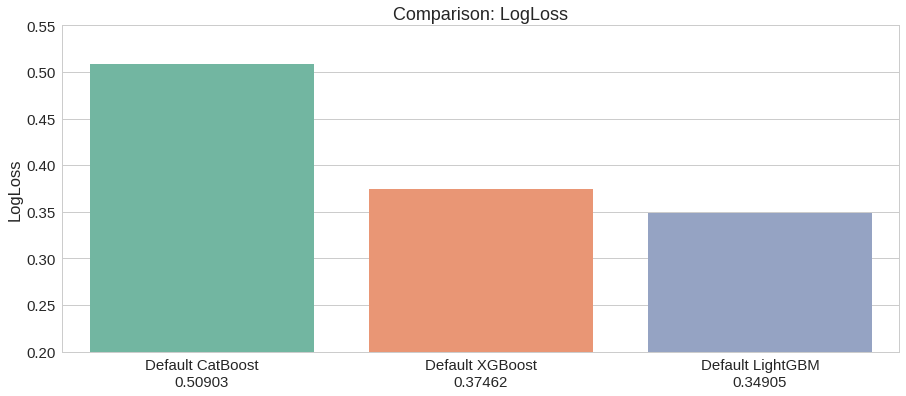

In [44]:
%pylab inline
import seaborn as sns

names = ['%s\n%.5f' % (name, loss) for name, loss in zip(res_df.index, res_df['LogLoss'])]

plt.figure(figsize=(15,6))
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
g = sns.barplot(x=res_df.index, y="LogLoss", data=res_df, palette='Set2')
g.set(ylim=(0.2, 0.55), ylabel='LogLoss', title='Comparison: LogLoss')
_ = g.set_xticklabels(names)

###### F-measure 

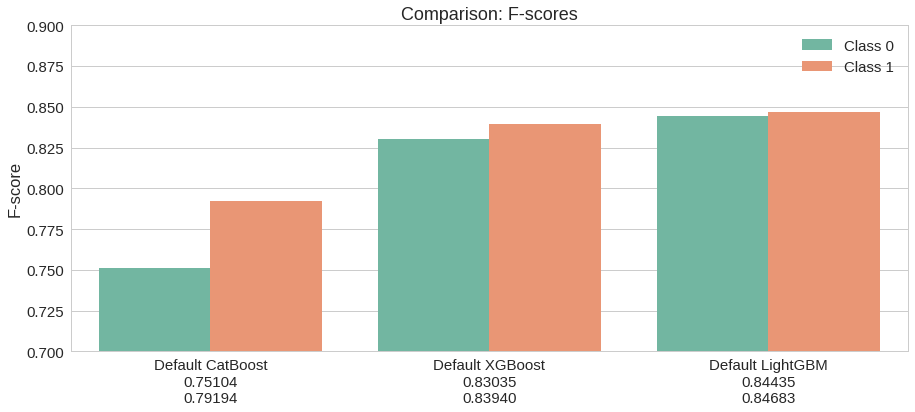

In [104]:
f = res_df.rename(columns={"F-measure_Class0": "Class 0", "F-measure_Class1": "Class 1"})
f = pd.DataFrame(f[['Class 0', 'Class 1']].stack(), columns=['F-measure'])

names = ['{}\n{:.5f}\n{:.5f}'.format(name, f1_0, f1_1) for name, f1_0, f1_1
         in zip(res_df.index, res_df['F-measure_Class0'], res_df['F-measure_Class1'])]

plt.figure(figsize=(15,6))
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
g = sns.barplot(x=f.index.get_level_values(0), y="F-measure", hue=f.index.get_level_values(1),
                data=f, palette='Set2')
g.set(ylim=(0.7, 0.9), ylabel='F-score', title='Comparison: F-scores')
_ = g.set_xticklabels(names)

##### Average runtime

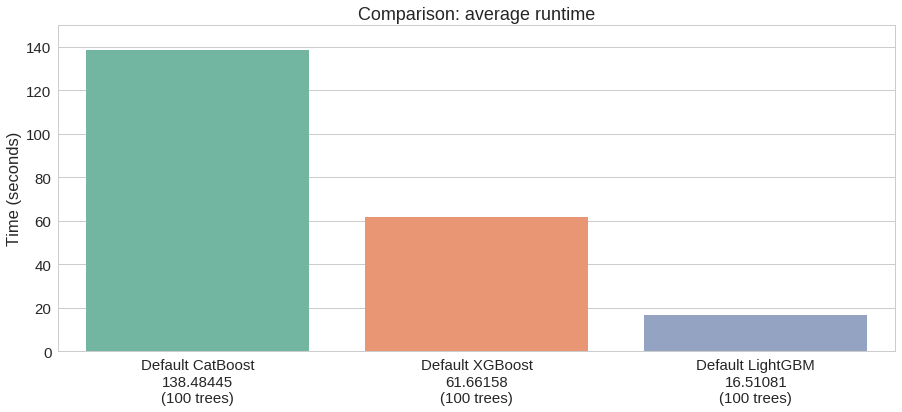

In [107]:
names = ['{}\n{:.5f}\n({} trees)'.format(name, loss, tree) for name, loss, tree in 
         zip(res_df.index, res_df['MeanRuntime'], res_df['NumberOfTrees'])]

plt.figure(figsize=(15,6))
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
g = sns.barplot(x=res_df.index, y="MeanRuntime", data=res_df, palette='Set2')
g.set(ylim=(0., 150), ylabel='Time (seconds)', title='Comparison: average runtime')
_ = g.set_xticklabels(names)

In [120]:
print '\n\nIn this task CatBoost is on average\n\n\t\t{:.1f} times slower than XGBoost \n\t\t{:.1f} times slower than LightGBM\n'.format(
    res_df['MeanRuntime'][0]/res_df['MeanRuntime'][1],
    res_df['MeanRuntime'][0]/res_df['MeanRuntime'][2]
)



In this task CatBoost is on average

		2.2 times slower than XGBoost 
		8.4 times slower than LightGBM



Теперь ограничим 5000.

# n_estimators = 5000

## XGBoost

In [15]:
%%time
xgb_result_moretrees = run_default(XGBExperiment, "XGBoost", n_estimators=5000)

Default XGBoost result on cv:

logloss = 0.3578022
best_n_estimators = 348
params = {'colsample_bytree': 1.0, 'silent': 1, 'eval_metric': 'logloss', 'colsample_bylevel': 1.0, 'min_child_weight': 1, 'subsample': 1.0, 'eta': 0.3, 'objective': 'binary:logistic', 'alpha': 0, 'seed': 0, 'max_depth': 6, 'gamma': 0, 'lambda': 1}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

For seed=0 Test's logloss : 0.35183
For seed=1 Test's logloss : 0.35183
For seed=2 Test's logloss : 0.35183
For seed=3 Test's logloss : 0.35183

             precision    recall  f1-score   support

          0       0.86      0.83      0.85      2500
          1       0.83      0.87      0.85      2500

avg / total       0.85      0.85      0.85      5000

For seed=4 Test's logloss : 0.35183

Test's logloss mean: 0.35183, Test's logloss std: 0.00000

Mean f-score for class 0: 0.84507
Mean f-score for class 1: 0.85121

Mean average f-score: 0.84814


Durations:
[241.1426179409027, 224.8253309726715, 219.6575419902

## LightXGB 

In [13]:
%%time
lgb_result_moretrees = run_default(LGBExperiment, "LightGBM", n_estimators=5000)

Default LightGBM result on cv:

logloss = 0.353624568878
best_n_estimators = 130
params = {'num_leaves': 127, 'verbose': -1, 'bagging_seed': 3, 'learning_rate': 0.1, 'data_random_seed': 1, 'min_data_in_leaf': 100, 'bagging_fraction': 1.0, 'metric': 'binary_logloss', 'feature_fraction_seed': 2, 'lambda_l1': 0, 'bagging_freq': 1, 'lambda_l2': 0, 'max_bin': 255, 'objective': 'binary', 'drop_seed': 4, 'min_sum_hessian_in_leaf': 10, 'feature_fraction': 1.0}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

For seed=0 Test's logloss : 0.34620
For seed=1 Test's logloss : 0.34620
For seed=2 Test's logloss : 0.34620
For seed=3 Test's logloss : 0.34620

             precision    recall  f1-score   support

          0       0.86      0.84      0.85      2500
          1       0.84      0.86      0.85      2500

avg / total       0.85      0.85      0.85      5000

For seed=4 Test's logloss : 0.34620

Test's logloss mean: 0.34620, Test's logloss std: 0.00000

Mean f-score for class 0: 0.8469

## CatBoost 

In [14]:
%%time
cab_result_moretrees = run_default(CABExperiment, "CatBoost", n_estimators=5000)

Default CatBoost result on cv:

logloss = 0.34090409098
best_n_estimators = 5000
params = {'rsm': 1.0, 'random_seed': 0, 'verbose': False, 'learning_rate': 0.03, 'ctr_border_count': 16, 'ctr_description': ['Borders', 'Counter'], 'depth': 6, 'fold_len_multiplier': 2, 'loss_function': 'Logloss', 'iterations': 5000, 'l2_leaf_reg': 3, 'leaf_estimation_method': 'Newton', 'gradient_iterations': 10, 'border_count': 128, 'used_ram_limit': 100000000000}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

For seed=0 Test's logloss : 0.33208
For seed=1 Test's logloss : 0.33159
For seed=2 Test's logloss : 0.33204
For seed=3 Test's logloss : 0.33398

             precision    recall  f1-score   support

          0       0.87      0.84      0.86      2500
          1       0.85      0.87      0.86      2500

avg / total       0.86      0.86      0.86      5000

For seed=4 Test's logloss : 0.33430

Test's logloss mean: 0.33280, Test's logloss std: 0.00112

Mean f-score for class 0: 0.85686
Mean f

In [17]:
results_moretrees = [
    cab_result_moretrees,
    xgb_result_moretrees,
    lgb_result_moretrees,
]
more_df = pd.DataFrame(np.array(results_moretrees), 
            columns=['LogLoss', 'F-measure_Class0', 'F-measure_Class1', 
                     'F-measure', 'MeanRuntime', 'NumberOfTrees'], 
            index = ['Default CatBoost', 'Default XGBoost', 'Default LightGBM'])
more_df['NumberOfTrees'] = more_df['NumberOfTrees'].astype(int)
more_df.round(5)

,LogLoss,F-measure_Class0,F-measure_Class1,F-measure,MeanRuntime,NumberOfTrees
Default CatBoost,0.33280,0.85686,0.86123,0.85905,6757.48739,5000
Default XGBoost,0.35183,0.84507,0.85121,0.84814,227.66527,348
Default LightGBM,0.34620,0.84693,0.84984,0.84839,20.25777,130


In [20]:
more_df.to_csv('../results/results_reviews_moretrees.csv')

In [15]:
more_df = pd.read_csv('../results/results_reviews_moretrees.csv', index_col=0)
more_df.round(5)

,LogLoss,F-measure_Class0,F-measure_Class1,F-measure,MeanRuntime,NumberOfTrees
Default CatBoost,0.33280,0.85686,0.86123,0.85905,6757.48739,5000
Default XGBoost,0.35183,0.84507,0.85121,0.84814,227.66527,348
Default LightGBM,0.34620,0.84693,0.84984,0.84839,20.25777,130


##### LogLoss

Populating the interactive namespace from numpy and matplotlib


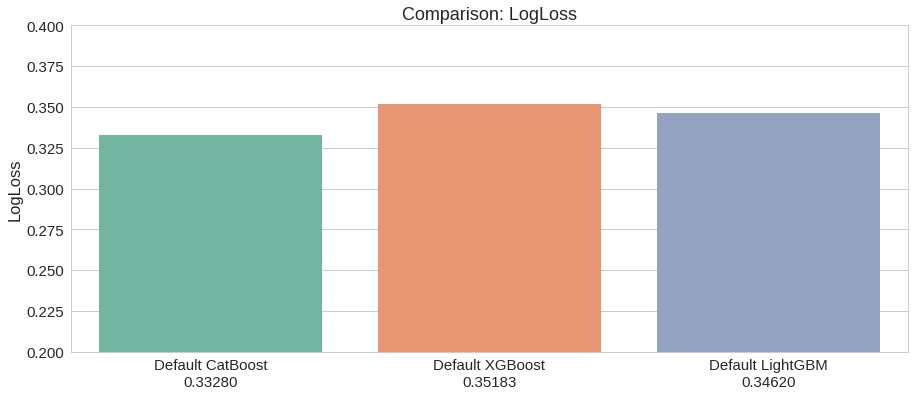

In [16]:
%pylab inline
import seaborn as sns

names = ['%s\n%.5f' % (name, loss) for name, loss in zip(more_df.index, more_df['LogLoss'])]

plt.figure(figsize=(15,6))
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
g = sns.barplot(x=more_df.index, y="LogLoss", data=more_df, palette='Set2')
g.set(ylim=(0.2, 0.4), ylabel='LogLoss', title='Comparison: LogLoss')
_ = g.set_xticklabels(names)

##### F-measure

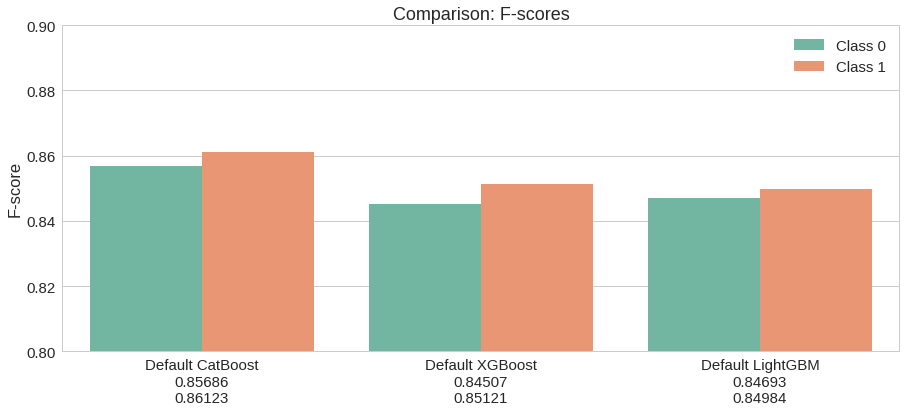

In [17]:
f = more_df.rename(columns={"F-measure_Class0": "Class 0", "F-measure_Class1": "Class 1"})
f = pd.DataFrame(f[['Class 0', 'Class 1']].stack(), columns=['F-measure'])

names = ['{}\n{:.5f}\n{:.5f}'.format(name, f1_0, f1_1) for name, f1_0, f1_1
         in zip(more_df.index, more_df['F-measure_Class0'], more_df['F-measure_Class1'])]

plt.figure(figsize=(15,6))
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
g = sns.barplot(x=f.index.get_level_values(0), y="F-measure", hue=f.index.get_level_values(1),
                data=f, palette='Set2')
g.set(ylim=(0.8, 0.9), ylabel='F-score', title='Comparison: F-scores')
_ = g.set_xticklabels(names)

##### Average runtime

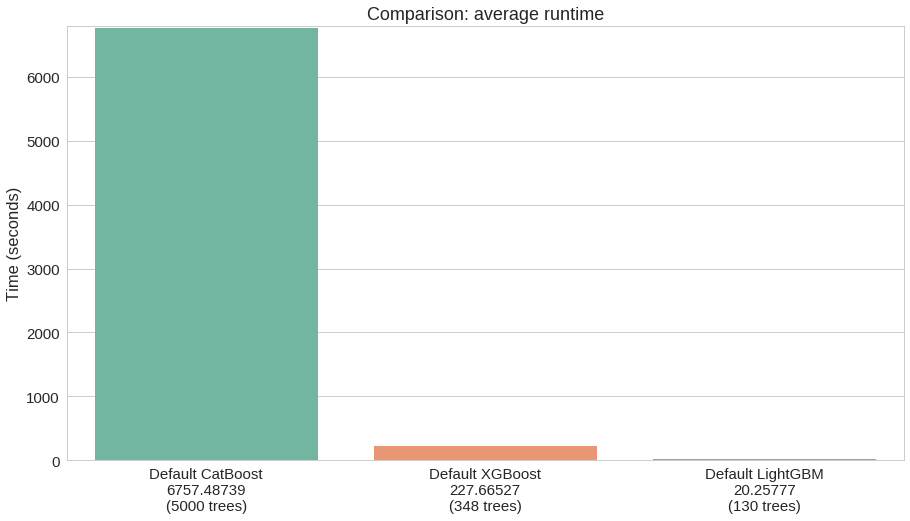

In [19]:
names = ['{}\n{:.5f}\n({} trees)'.format(name, loss, tree) for name, loss, tree in 
         zip(more_df.index, more_df['MeanRuntime'], more_df['NumberOfTrees'])]

plt.figure(figsize=(15,8))
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
g = sns.barplot(x=more_df.index, y="MeanRuntime", data=more_df, palette='Set2')
g.set(ylim=(0., 6800), ylabel='Time (seconds)', title='Comparison: average runtime')
_ = g.set_xticklabels(names)